# **Deep Learning HW4 - Problem 1**
### **Ehsan Sharifian 400201529**

---

## Initialization

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
%pwd

Mounted at /content/drive


'/content'

In [2]:
import os 
import datetime
import time, random, math, string
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Masking, GRU, Dropout
from keras import metrics
from keras.utils import plot_model

## Part a

### Preparing Data:

In [3]:
with open('./drive/MyDrive/Deep Learning/HW04/Q1/ferdousi.txt') as f:
    lines = f.readlines()
half_verses = lines[2::]
half_verses = [[*half_verse.replace("\n","")] for half_verse in half_verses]
print(f"num of half verses = {len(half_verses)}")
verses = []
for i in np.arange(len(half_verses)//2):
  verses.append(half_verses[2*i]+ [' - '] + half_verses[2*i+1])
print(f"num of verses = {len(verses)}")

num of half verses = 99217
num of verses = 49608


In [4]:
MAX_LENGTH = max([len(verse) for verse in verses])
print(f"max len of verses = {MAX_LENGTH}")

max len of verses = 64


### Creating the vocabulary:

In [5]:
SOS_token = 0
EOS_token = 1

In [6]:
from collections import Counter
cnt = Counter(np.concatenate(verses,axis=0))
ks = list(cnt.keys())
vs = np.arange(2,len(cnt.keys())+3)

In [7]:
character2index = {k:v for k,v in zip(ks,vs)}
character2index['SOS']=SOS_token
character2index['EOS']=EOS_token
UNK_token = len(character2index)
character2index['UNK']=UNK_token

In [8]:
index2character = {k:v for k,v in zip(vs,ks)}
index2character[SOS_token]='SOS'
index2character[EOS_token]='EOS'
index2character[UNK_token]='UNK'

In [9]:
def get_sen_vec(sentence):
  if type(sentence)==str:
    sentence = [*sentence]
  sen_vec = [get_ind(character) for character in sentence]
  s = [SOS_token] + sen_vec + [EOS_token]+[UNK_token]*(MAX_LENGTH-len(sen_vec))
  return s
def get_ind(character):
  if character in character2index.keys():
    ind = character2index[character]
  else:
    ind = UNK_token
  return ind

In [10]:
src = [get_sen_vec(v) for v in verses]
trg = src[1:]
src = src[:-1]

In [11]:
encoder_input_data = np.array(src).reshape(len(src),MAX_LENGTH+2,1)
decoder_input_data = np.array(trg).reshape(len(src),MAX_LENGTH+2,1)

num_encoder_tokens = len(index2character)
num_decoder_tokens = len(index2character)

decoder_target_data = np.concatenate([decoder_input_data[:,1:,:],np.zeros((len(src),1,1),dtype=int)+UNK_token],axis=1)

### lstm model:

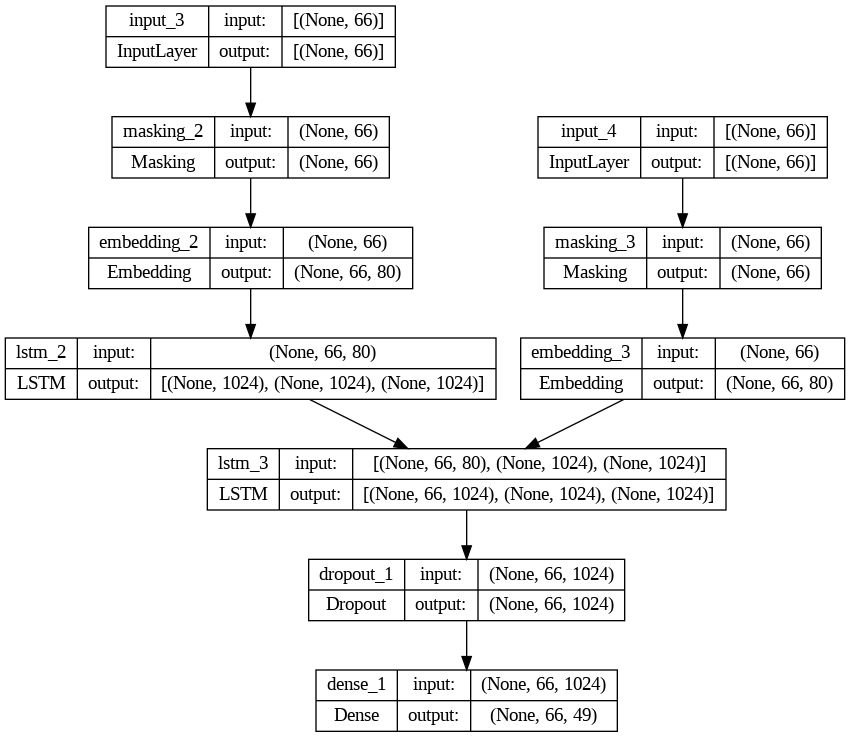

In [15]:
encoder_dim = 80
rnn_units = 1024

lstm_encoder_inputs = Input(shape=(encoder_input_data.shape[1],))
lstm_encoder_mask = Masking(mask_value=UNK_token)
lstm_encoder_embed = Embedding(num_encoder_tokens, encoder_dim)
encoder_lstm = LSTM(rnn_units,return_state=True)
x = lstm_encoder_inputs
x = lstm_encoder_mask(x)
x = lstm_encoder_embed(x)
x, state_h, state_c = encoder_lstm(x)
lstm_encoder_states = [state_h, state_c]

lstm_decoder_inputs = Input(shape=(encoder_input_data.shape[1],))
lstm_decoder_mask = Masking(mask_value=UNK_token)
lstm_decoder_embed = Embedding(num_decoder_tokens, encoder_dim)
decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
lstm_decoder_dense = Dense(num_decoder_tokens, activation='softmax')
x = lstm_decoder_inputs
x = lstm_decoder_mask(x)
x = lstm_decoder_embed(x)
x,_,_ = decoder_lstm(x, initial_state=lstm_encoder_states)
x = Dropout(0.2)(x)
lstm_decoder_outputs = lstm_decoder_dense(x)

lstm_model = Model([lstm_encoder_inputs, lstm_decoder_inputs], lstm_decoder_outputs)
plot_model(lstm_model, show_shapes=True)

In [16]:
batch_size = 64
epochs = 10

lstm_checkpoint_filepath = 'best_lstm_model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=lstm_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2
    )
    
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

! rm -rf lstm-logs
%load_ext tensorboard
logdir = os.path.join("lstm-logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
lstm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lstm_history = lstm_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[model_checkpoint_callback, reduce_lr, early_stopping,tensorboard])

Epoch 1/10
621/621 [==============================] - 63s 96ms/step - loss: 1.8091 - accuracy: 0.4803 - val_loss: 1.4088 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 2/10
621/621 [==============================] - 57s 92ms/step - loss: 1.2491 - accuracy: 0.6269 - val_loss: 1.1738 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 3/10
621/621 [==============================] - 58s 93ms/step - loss: 1.0776 - accuracy: 0.6739 - val_loss: 1.0738 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 4/10
621/621 [==============================] - 57s 91ms/step - loss: 0.9933 - accuracy: 0.6974 - val_loss: 1.0230 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 5/10
621/621 [==============================] - 57s 91ms/step - loss: 0.9370 - accuracy: 0.7137 - val_loss: 0.9944 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 6/10
621/621 [==============================] - 57s 92ms/step - loss: 0.8935 - accuracy: 0.7262 - val_loss: 0.9800 - val_accuracy: 0.7093 - lr: 0.0010
Epoch 7/10
621/621 [==============================] - 57s 

In [18]:
lstm_model.load_weights(lstm_checkpoint_filepath)

### Plot loss and accuracy curves

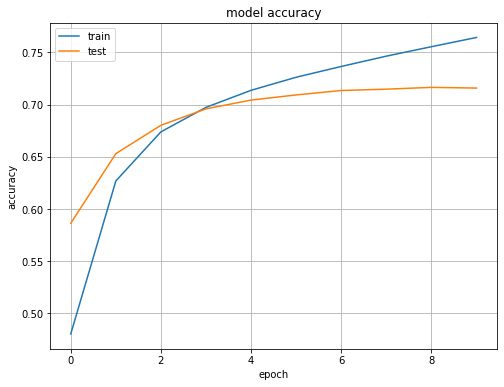

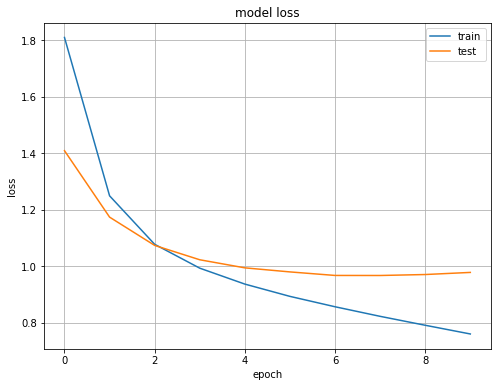

In [23]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

### verse generation

In [29]:
def inference_model(model, rnn_units):
    encoder_model = Model(lstm_encoder_inputs, lstm_encoder_states)

    lstm_decoder_state_input_h = Input(shape=(rnn_units,))
    lstm_decoder_state_input_c = Input(shape=(rnn_units,))
    lstm_decoder_states_inputs = [lstm_decoder_state_input_h, lstm_decoder_state_input_c]
    lstm_decoder_outputs, state_h, state_c = decoder_lstm(
        lstm_decoder_embed(lstm_decoder_mask(lstm_decoder_inputs)), initial_state=lstm_decoder_states_inputs)
    lstm_decoder_states = [state_h, state_c]
    lstm_decoder_outputs = lstm_decoder_dense(lstm_decoder_outputs)
    decoder_model = Model(
        [lstm_decoder_inputs] + lstm_decoder_states_inputs,
        [lstm_decoder_outputs] + lstm_decoder_states)

    return encoder_model, decoder_model

In [30]:
encoder_model, decoder_model = inference_model(lstm_model, rnn_units=rnn_units)

In [20]:
def verse_generator(input_verse, encoder, decoder):
    output_verse = ''
    next_char = 'SOS'
    h_st, c_st = encoder.predict(input_verse)
    while next_char != 'EOS' and len(output_verse) <= MAX_LENGTH:
        probs, h_st, c_st = decoder.predict([np.array(character2index[next_char], int).reshape((1,1)),h_st,c_st])
        probs = probs.flatten()
        next_char = index2character[np.random.choice(range(len(probs)), p=probs)]
        if (next_char != 'EOS'):
          output_verse += next_char
    return output_verse

def input_generator(encoder_input_data):
    input_seq_indices = np.expand_dims(encoder_input_data, 0)
    input_seq_chars = ''
    for i in input_seq_indices[0]:
        char = index2character[i[0]]
        if (char != 'SOS' and char != 'EOS' and char != 'UNK'):
          input_seq_chars += char
    return input_seq_indices, input_seq_chars

def feed_input_verse_take_output_verse(encoder_input_data, encoder, decoder):
    input_seq_indices, input_seq_chars = input_generator(encoder_input_data)
    output_seq_chars = verse_generator(input_seq_indices, encoder, decoder)
    print(f"Input Verse: {input_seq_chars}")
    print('-----------------------------------------------------------------------')
    print(f"Output Vrese: {output_seq_chars}")

In [38]:
feed_input_verse_take_output_verse(encoder_input_data[1], encoder_model, decoder_model)

1/1 [==============================] - 0s 15ms/step
Input Verse: خداوند نام و خداوند جای - خداوند روزی ده رهنمای
-----------------------------------------------------------------------
Output Vrese: یکی مایه کر زان فغان برکشید - به آوردگه با پیامش بدید


## Part b


### gru model:

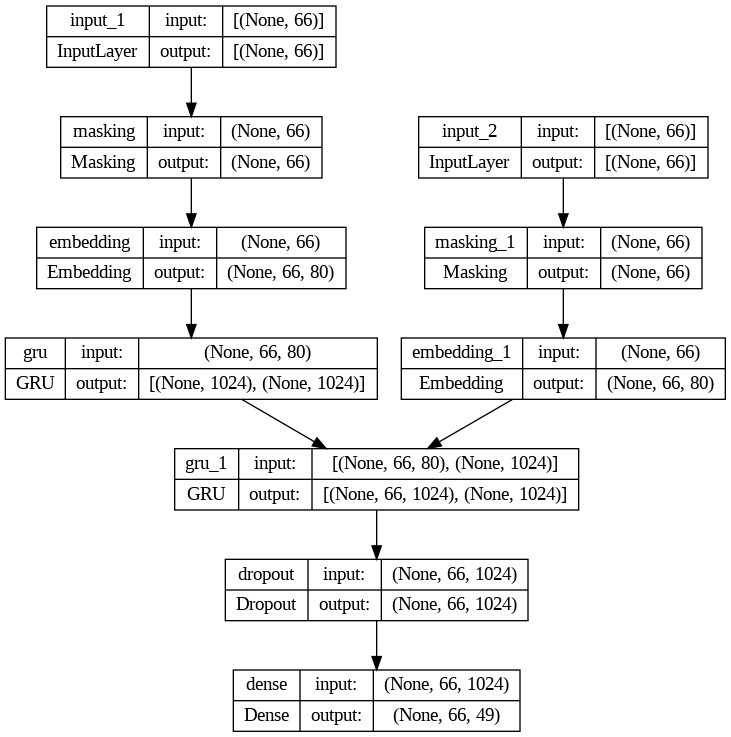

In [12]:
encoder_dim = 80
rnn_units = 1024

gru_encoder_inputs = Input(shape=(encoder_input_data.shape[1],))
gru_encoder_mask = Masking(mask_value=UNK_token)
gru_encoder_embed = Embedding(num_encoder_tokens, encoder_dim)
encoder_gru = GRU(rnn_units,return_state=True)
x = gru_encoder_inputs
x = gru_encoder_mask(x)
x = gru_encoder_embed(x)
x, state_h = encoder_gru(x)
gru_encoder_states = [state_h]

gru_decoder_inputs = Input(shape=(encoder_input_data.shape[1],))
gru_decoder_mask = Masking(mask_value=UNK_token)
gru_decoder_embed = Embedding(num_decoder_tokens, encoder_dim)
decoder_gru = GRU(rnn_units, return_sequences=True, return_state=True)
gru_decoder_dense = Dense(num_decoder_tokens, activation='softmax')
x = gru_decoder_inputs
x = gru_decoder_mask(x)
x = gru_decoder_embed(x)
x,_ = decoder_gru(x, initial_state=gru_encoder_states)
x = Dropout(0.2)(x)
gru_decoder_outputs = gru_decoder_dense(x)

gru_model = Model([gru_encoder_inputs, gru_decoder_inputs], gru_decoder_outputs)
plot_model(gru_model, show_shapes=True)

In [13]:
batch_size = 64
epochs = 10

gru_checkpoint_filepath = 'best_gru_model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=gru_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2
    )
    
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

! rm -rf gru-logs
%load_ext tensorboard
logdir = os.path.join("gru-logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [14]:
gru_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
gru_history = gru_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[model_checkpoint_callback, reduce_lr, early_stopping,tensorboard])

Epoch 1/10
621/621 [==============================] - 53s 73ms/step - loss: 1.8293 - accuracy: 0.4773 - val_loss: 1.4569 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 2/10
621/621 [==============================] - 46s 74ms/step - loss: 1.2853 - accuracy: 0.6173 - val_loss: 1.1938 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 3/10
621/621 [==============================] - 46s 74ms/step - loss: 1.1059 - accuracy: 0.6669 - val_loss: 1.1015 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 4/10
621/621 [==============================] - 46s 74ms/step - loss: 1.0199 - accuracy: 0.6910 - val_loss: 1.0475 - val_accuracy: 0.6891 - lr: 0.0010
Epoch 5/10
621/621 [==============================] - 47s 76ms/step - loss: 0.9645 - accuracy: 0.7067 - val_loss: 1.0199 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 6/10
621/621 [==============================] - 47s 76ms/step - loss: 0.9317 - accuracy: 0.7161 - val_loss: 1.0043 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 7/10
621/621 [==============================] - 46s 

In [15]:
gru_model.load_weights(gru_checkpoint_filepath)

### Plot loss and accuracy curves

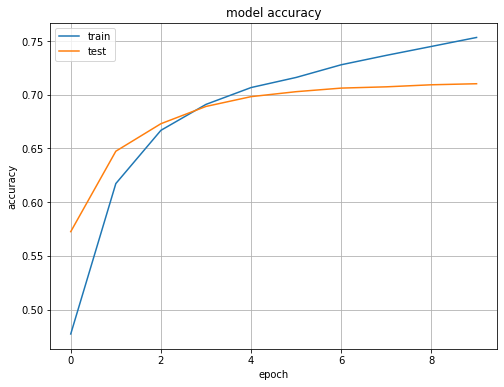

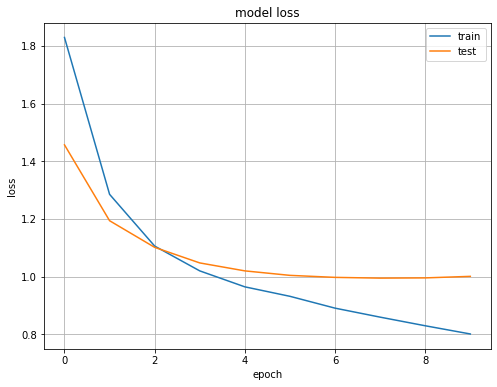

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(8, 6))
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(8, 6))
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

### verse generation

In [17]:
def inference_model(model, rnn_units):
    encoder_model = Model(gru_encoder_inputs, gru_encoder_states)

    gru_decoder_state_input_h = Input(shape=(rnn_units,))
    gru_decoder_states_inputs = [gru_decoder_state_input_h]
    gru_decoder_outputs, state_h = decoder_gru(
        gru_decoder_embed(gru_decoder_mask(gru_decoder_inputs)), initial_state=gru_decoder_states_inputs)
    gru_decoder_states = [state_h]
    gru_decoder_outputs = gru_decoder_dense(gru_decoder_outputs)
    decoder_model = Model(
        [gru_decoder_inputs] + gru_decoder_states_inputs,
        [gru_decoder_outputs] + gru_decoder_states)

    return encoder_model, decoder_model

In [18]:
encoder_model, decoder_model = inference_model(gru_model, rnn_units=rnn_units)

In [22]:
def verse_generator(input_verse, encoder, decoder):
    output_verse = ''
    next_char = 'SOS'
    h_st = encoder.predict(input_verse)
    while next_char != 'EOS' and len(output_verse) <= MAX_LENGTH:
        probs, h_st = decoder.predict([np.array(character2index[next_char], int).reshape((1,1)),h_st])
        probs = probs.flatten()
        next_char = index2character[np.random.choice(range(len(probs)), p=probs)]
        if (next_char != 'EOS'):
          output_verse += next_char
    return output_verse

def input_generator(encoder_input_data):
    input_seq_indices = np.expand_dims(encoder_input_data, 0)
    input_seq_chars = ''
    for i in input_seq_indices[0]:
        char = index2character[i[0]]
        if (char != 'SOS' and char != 'EOS' and char != 'UNK'):
          input_seq_chars += char
    return input_seq_indices, input_seq_chars

def feed_input_verse_take_output_verse(encoder_input_data, encoder, decoder):
    input_seq_indices, input_seq_chars = input_generator(encoder_input_data)
    output_seq_chars = verse_generator(input_seq_indices, encoder, decoder)
    print(f"Input Verse: {input_seq_chars}")
    print('-----------------------------------------------------------------------')
    print(f"Output Vrese: {output_seq_chars}")

In [24]:
feed_input_verse_take_output_verse(encoder_input_data[1], encoder_model, decoder_model)

1/1 [==============================] - 0s 15ms/step
Input Verse: خداوند نام و خداوند جای - خداوند روزی ده رهنمای
-----------------------------------------------------------------------
Output Vrese: همی تاخت تا جامه ها بر برش - بهرجسی چون در بیابان بود
